# Machine Learning modeling - World Food Program Disaster Relief -

*@XavierTorres*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter

In [3]:
df = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v10.csv', sep=";")

## Data pre-processing

In [4]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFEC

In [5]:
# Arranging columns

df = df[[
    # cols from cyclones
    'SID', 'NAME', 'ISO',  'ISO_TIME', 'COORDS', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 
    
    # Target 
    'TOTAL_AFFECTED']]

In [6]:
df.head(3)

,SID,NAME,ISO,ISO_TIME,COORDS,YEAR,BASIN,SUB BASIN,NATURE,TOTAL_HRS,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","[[35.67, 130.99], [38.35, 135.07], [38.82, 136...",1949,WP,WP,TS,0,...,67.666098,NaN,258.911917,2.867878,36.728,Low,1.198300e+07,5.803981e+06,3.320907e+06,194046
1,1950241N23140,JANE,JPN,"['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]",1950,WP,WP,ET,6,...,67.666098,NaN,258.911917,2.867878,36.728,Low,3.160822e+07,1.559196e+07,1.018936e+07,642117
2,1951224N12316,CHARLIE,JAM,"['1951-08-17 21:00:00', '1951-08-18 12:00:00']","[[17.34, -75.41], [18.3, -79.4]]",1951,NAm,CS,TS,15,...,64.770000,NaN,152.453647,2.578304,66.231,Low,1.689243e+06,1.687083e+06,1.195052e+06,20200


- **Checking nulls**

In [7]:
# Checking quantity of missing data. Reusing code from Fabi
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

In [8]:
null_cols(df)

,Feature,% Null rows
0,TOTAL_DAMAGE_(000$),31.741294
1,34KN_ASSETS,23.184080
2,64KN_ASSETS,23.184080
3,96KN_ASSETS,23.184080
4,"Air transport, freight (million ton-km)",15.820896
5,TOTAL_DEATHS,13.333333
6,pop_max_64_adj,7.960199
7,pop_max_34_adj,7.960199
8,pop_max_50_adj,7.960199
9,GDP growth (annual %),3.980100


- **BASIN and SUBBASIN**: 'MM' value means missing, and **USA_SSHS** column with value -5 = Unknown [XX]:

In [9]:
df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan) 
df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan) 

- As damage in '000 USD is time-money sensitive, we can use the CPI for that data point to calculate **"Total Damage Adjusted"** 
by dividing Total Damage by the CPI. We then drop columns for Damage and CPI.
CPI meaning = https://en.wikipedia.org/wiki/Consumer_price_index

In [10]:
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)

In [11]:
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

319

- Trying to create a calculated column that better represents de relative dimension **of exposed assets**. We have several columns for assets exposed depending of windspeed for 34kn+, 64kn+ and 96kn+. Let's add these columns to create a new column:

In [12]:
df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
df = df.drop(['34KN_ASSETS', '64KN_ASSETS','96KN_ASSETS'], axis=1)

 - Extracting **month of cyclone**

In [13]:
df['MONTH'] = df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

- **Transform 'Income_Level'** categories to ordered integers and **YEAR, BASIN, SUB BASIN and USA_SSHS** into Category Type

In [14]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [15]:
df['YEAR'] = df['YEAR'].astype('category')
df['BASIN'] = df['BASIN'].astype('category')
df['SUB BASIN'] = df['SUB BASIN'].astype('category')
df['NATURE'] = df['NATURE'].astype('category')
df['USA_SSHS'] = df['USA_SSHS'].astype('category')

- **Arranging columns**

In [16]:
df.shape

(1005, 39)

In [17]:
df.columns

Index(['SID', 'NAME', 'ISO', 'ISO_TIME', 'COORDS', 'YEAR', 'BASIN',
       'SUB BASIN', 'NATURE', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'MONTH'],
      dtype='

In [18]:
#taking out from model=    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'ISO_TIME',
# Arranging columns

df = df[[
    # cols from cyclones
    'BASIN', 'SUB BASIN', 'NATURE',
       'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN','TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',  'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 
    
    # Target 
    'TOTAL_AFFECTED']]

- **Check SKEWENESS and apply log**

In [19]:
#determine index for continous variables
num_feats = df.dtypes[df.dtypes != 'object'].index

#Calculate skew and sort
skew_feats = df[num_feats].skew().sort_values(ascending = False)
skewness = pd.DataFrame({'Skew': skew_feats})

In [20]:
skewness

,Skew
TOTAL_DEATHS,28.579526
TOTAL_DAMAGE_(000$)_Adjusted,12.376678
Population density (people per sq. km of land area),10.706739
TOTAL_AFFECTED,7.345349
Arable land (hectares per person),5.368166
pop_max_50_adj,4.056652
pop_max_64_adj,3.540787
pop_max_34_adj,3.099740
CALC_assets_emdat,2.863852
"Air transport, freight (million ton-km)",2.689838


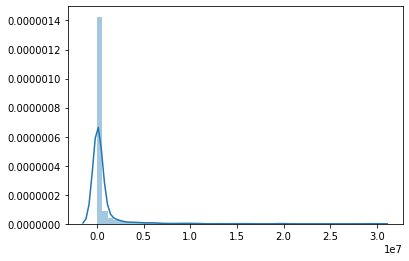

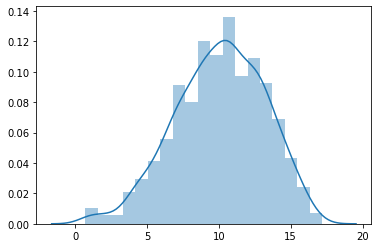

<Figure size 432x288 with 0 Axes>

In [21]:
# Checking distribution for one feature---reusing code from Juber
ax=sns.distplot(df['TOTAL_AFFECTED'].values)

plt.show()
plt.clf()

log_affected=np.log(df['TOTAL_AFFECTED'].values)
ax=sns.distplot(log_affected)

plt.show()
plt.clf()

In [22]:
# Creating list of features to transform, for skew values above 2

feats_to_log = skewness[skewness['Skew'] > 2].index

In [23]:
feats_to_log

Index(['TOTAL_DEATHS', 'TOTAL_DAMAGE_(000$)_Adjusted',
       'Population density (people per sq. km of land area)', 'TOTAL_AFFECTED',
       'Arable land (hectares per person)', 'pop_max_50_adj', 'pop_max_64_adj',
       'pop_max_34_adj', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Net flows from UN agencies US$'],
      dtype='object')

In [24]:
# as log cannot be perfomed to negative numbers, a common technique for handling negative values is to 
# add a constant value to the data prior to applying the log transform. The transformation is 
#therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small 
#positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show 
# that a = b – min(Y), where b is either a small number or is 1.
# Source : https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html

for item in feats_to_log:
    #df[item]=np.log((df[item] + 1 - df[item].min()).values)
    df[item] = df[item].apply(lambda x: math.log(x, 10) if x>0 else 0)
    

In [25]:
df[feats_to_log].describe()

,TOTAL_DEATHS,TOTAL_DAMAGE_(000$)_Adjusted,Population density (people per sq. km of land area),TOTAL_AFFECTED,Arable land (hectares per person),pop_max_50_adj,pop_max_64_adj,pop_max_34_adj,CALC_assets_emdat,"Air transport, freight (million ton-km)",Adjusted savings: education expenditure (% of GNI),Net flows from UN agencies US$
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,1.114535,2.082295,2.094491,4.371673,-1.003523,5.862670,5.158980,6.354219,8.355095,2.215947,0.452900,5.598122
std,0.823842,1.695371,0.568897,1.353087,0.487073,2.238822,2.462603,2.091023,4.861676,1.472691,0.212688,3.017808
min,0.000000,-0.925049,0.251958,0.301030,-3.371253,0.000000,0.000000,0.000000,0.000000,-1.886057,-0.268507,0.000000
25%,0.477121,0.000000,1.700602,3.477121,-1.231704,5.767974,4.960574,6.309532,7.700307,1.085932,0.264818,6.012162
50%,1.079181,2.486741,2.160119,4.477121,-1.043418,6.568644,6.111959,6.980567,10.670626,2.478042,0.442729,7.079543
75%,1.672098,3.464999,2.479996,5.394553,-0.718925,7.192959,6.727481,7.494052,11.671027,3.324591,0.623938,7.496653
max,5.141029,6.213885,4.311325,7.471614,0.487050,8.508228,8.030877,8.575762,13.171017,4.633320,1.146438,8.264227


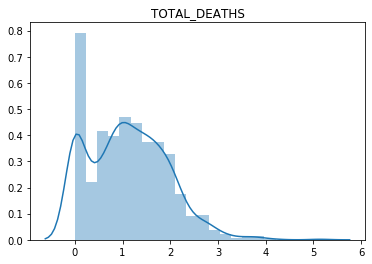

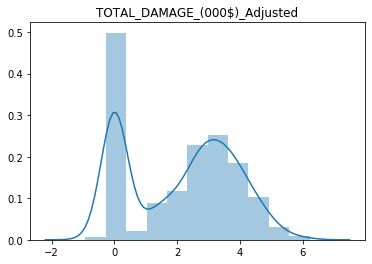

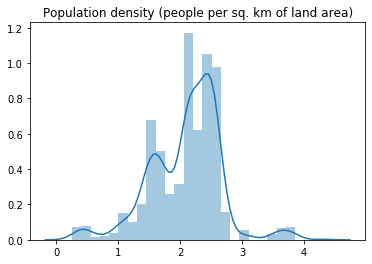

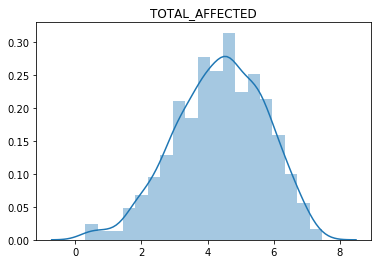

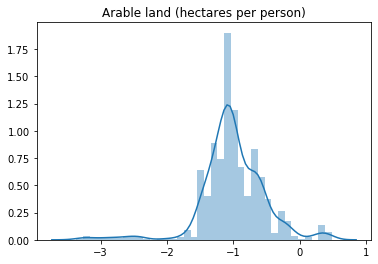

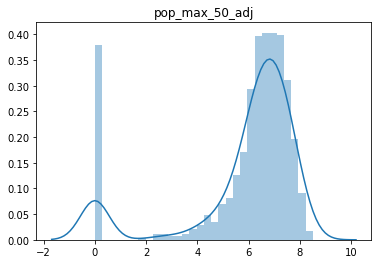

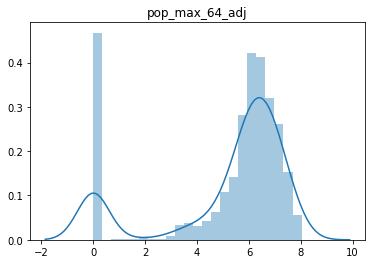

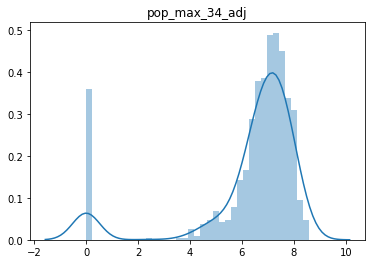

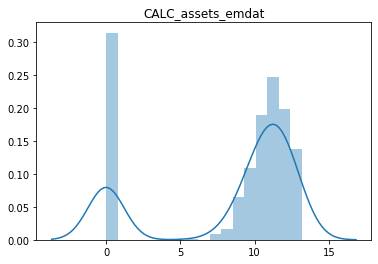

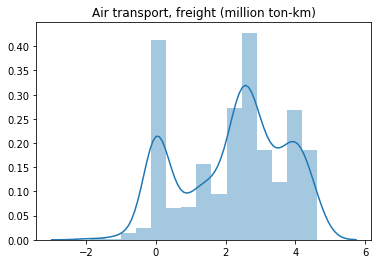

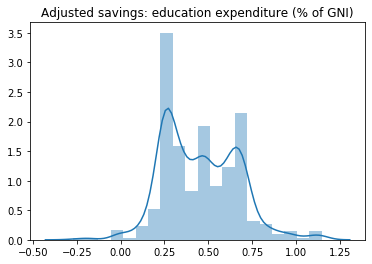

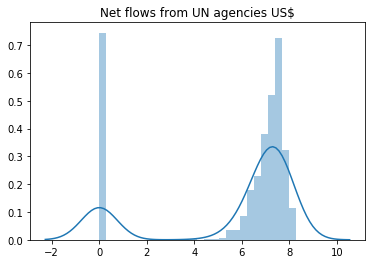

<Figure size 432x288 with 0 Axes>

In [26]:
for item in feats_to_log:
    ax=sns.distplot(df[item].values)
    ax.set_title(item);
    plt.show()
    plt.clf()


In [27]:
df.describe()

,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,WIND_CALC_MEAN,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,TOTAL_DAMAGE_(000$)_Adjusted,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
count,1005.000000,1005.000000,1005.000000,1005.000000,1001.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,...,1001.000000,996.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,7.780100,13.187065,2.121393,11.065672,59.718462,975.450806,12.047601,215.481903,90.011543,2.082295,...,70.647402,43.296536,2.094491,0.452900,47.065884,2.503483,6.354219,5.862670,5.158980,4.371673
std,2.762945,7.412493,3.811702,8.259346,25.080155,56.845274,6.586180,96.090666,31.633313,1.695371,...,7.252531,47.524739,0.568897,0.212688,22.016753,0.962048,2.091023,2.238822,2.462603,1.353087
min,1.000000,0.000000,0.000000,-1.000000,18.620690,0.000000,1.565217,2.000000,30.000000,-0.925049,...,41.762000,0.000000,0.251958,-0.268507,0.000000,1.000000,0.000000,0.000000,0.000000,0.301030
25%,7.000000,6.000000,0.000000,3.000000,40.000000,966.400000,7.666667,153.800000,62.400000,0.000000,...,67.136150,0.052346,1.700602,0.264818,23.959000,2.000000,6.309532,5.767974,4.960574,3.477121
50%,8.000000,15.000000,0.000000,9.000000,55.250000,981.857143,10.666667,260.750000,89.200000,2.486741,...,71.063000,27.669708,2.160119,0.442729,53.525000,2.000000,6.980567,6.568644,6.111959,4.477121
75%,10.000000,21.000000,3.000000,21.000000,75.705882,993.571429,14.411765,288.250000,114.700000,3.464999,...,75.164000,83.671391,2.479996,0.623938,64.917000,3.000000,7.494052,7.192959,6.727481,5.394553
max,12.000000,23.000000,12.000000,23.000000,150.000000,1013.000000,49.800000,358.000000,171.800000,6.213885,...,84.680488,328.790446,4.311325,1.146438,92.421000,4.000000,8.575762,8.508228,8.030877,7.471614


- **Apply min_max_scaler**

In [28]:
#df.shape

In [29]:
'''
# first we split df into categorical and numerical features, to merge later
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')
'''

"\n# first we split df into categorical and numerical features, to merge later\ndf_cat = df.select_dtypes(include='object')\ndf_num = df.select_dtypes(exclude='object')\n"

In [30]:
# min_max_scaler = preprocessing.MinMaxScaler()

In [31]:
# cols_num = df_num.columns #we'll use this later
# cols_num

In [32]:
# X = df_num.values
# x_scaled = min_max_scaler.fit_transform(X)
# df_num = pd.DataFrame(x_scaled)

In [33]:
# df_num.head()

In [34]:
# df_num.rename(columns = dict(zip(df_num.columns, cols_num)), inplace = True)

In [35]:
# df_num.head(5)

In [36]:
# df_num.shape

In [37]:
# df_cat.shape

Merging again df_num and df_cat

In [38]:
# df_scaled = pd.merge(df_cat, df_num, how='inner', left_index=True, right_index=True)

In [39]:
# df_scaled.head(20)

In [40]:
# df_scaled.shape

- **One hot encoding for categorical variables**

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 33 columns):
BASIN                                                  1005 non-null category
SUB BASIN                                              1005 non-null category
NATURE                                                 1005 non-null category
MONTH                                                  1005 non-null int32
TOTAL_HRS                                              1005 non-null int64
DAY_HRS                                                1005 non-null int64
NIGHT_HRS                                              1005 non-null int64
USA_SSHS                                               998 non-null category
WIND_CALC_MEAN                                         1001 non-null float64
PRES_CALC_MEAN                                         1005 non-null float64
STORM_SPD_MEAN                                         1005 non-null float64
STORM_DR_MEAN                                      

In [42]:
cat_feats = df.dtypes[df.dtypes == 'category'].index
cat_feats

Index(['BASIN', 'SUB BASIN', 'NATURE', 'USA_SSHS'], dtype='object')

In [43]:
feats_to_dummy = cat_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df,dummy], axis=1)

In [44]:
# Dropping dummed features
df = df.drop(feats_to_dummy, axis=1)

In [45]:
df.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB'

In [46]:
df.shape

(1005, 63)

In [47]:
#Deleting Basin and keeping subBasin because has higher granularity
#column arrangement 
df = df[[
    
     # here columns from cyclones dataset:
    'TOTAL_DEATHS',
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 
    
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',

         
    # here columns from World Bank Indicators dataset:
     'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
         
    # Target   
       'TOTAL_AFFECTED']]

In [48]:
df.shape

(1005, 57)

### Feature selection

In [49]:
# choosing the features to include in the model
# We take out 'TOTAL_DEATHS' because this input will not be available at the time of prediction
features1 = [   
     # here columns from cyclones dataset:
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 
    
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',

         
    # here columns from World Bank Indicators dataset:
     'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
         ]

In [50]:
# features2 . Deleting columns with high NaNs

features2 = [
 # here columns from cyclones dataset:
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       
    
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',

         
    # here columns from World Bank Indicators dataset:
     
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 
       'GDP per capita (constant 2010 US$)', 
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_64_adj',
         ]

In [51]:
# arnab feats

features3 = ['TOTAL_HRS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
             'V_LAND_KN', 'Population density (people per sq. km of land area)',
             'Rural population (% of total population)', 'Income_level_Final', 'pop_max_34_adj', 
             'pop_max_50_adj', 'pop_max_64_adj']

In [52]:
df = df[df['TOTAL_AFFECTED'] >0]

In [53]:
#some checks....
df['SUB BASIN_NAm'].unique()

array([0, 1], dtype=uint64)

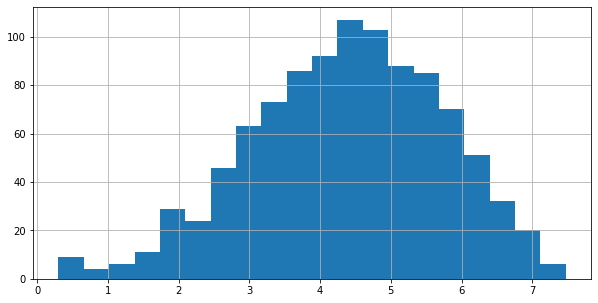

In [54]:
#some checks....
df['TOTAL_AFFECTED'].hist(bins=20, figsize=(10,5)) #this is logarithmic and scaled(0,1)

__________________

________________________

## Random forest model____________________________________

In [55]:
 #trim. Scaled and logged 1000 < x <5000000
# df_scaled =  df_scaled[df_scaled['TOTAL_AFFECTED'] > 0.4] 
# df_scaled =  df_scaled[df_scaled['TOTAL_AFFECTED'] < 0.9]
df.shape

(1005, 57)

In [56]:
# df_scaled.dropna(inplace = True)

In [57]:
from sklearn.impute import KNNImputer

In [58]:
imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df))
df_filled.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,2.622214,6.0,0.0,0.0,0.0,39.133333,1000.333333,19.0,91.444444,99.820,...,67.666098,45.385395,2.413152,0.457561,36.728,1.0,7.078566,6.763726,6.521257,5.287905
1,2.706718,9.0,6.0,0.0,6.0,76.400000,974.833333,23.0,37.666667,99.820,...,67.666098,45.385395,2.413152,0.457561,36.728,1.0,7.499800,7.192901,7.008147,5.807614
2,2.187521,8.0,15.0,0.0,15.0,88.500000,974.500000,15.5,283.500000,132.400,...,64.770000,18.684943,2.183138,0.411334,66.231,1.0,6.227692,6.227137,6.077387,4.305351
3,2.755112,12.0,15.0,0.0,15.0,84.488235,979.549020,3.0,161.647059,119.200,...,61.105000,0.000000,1.959351,0.440552,69.703,2.0,6.677611,6.478086,6.047187,4.778151
4,1.278754,7.0,3.0,2.0,1.0,83.920000,980.600000,10.8,291.400000,110.691,...,61.105000,0.000000,1.959351,0.440552,69.703,2.0,6.710185,6.445524,6.298531,2.012837


In [59]:
df_filled = df_filled.rename(columns = dict(zip(df_filled.columns, df.columns), inplace = True))

In [60]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [61]:
X.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'SUB BASIN_AS',
       'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA',
       'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI',
       'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS',
       'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS', 'NATURE_TS',
       'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0', 'USA_SSHS_-1.0',
       'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0', 'USA_SSHS_3.0',
       'USA_SSHS_4.0', 'USA_SSHS_5.0',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birt

In [62]:
X.shape

(1005, 55)

In [63]:
# X.to_csv(r'Data_output/X.csv', index = False, sep = ';')

In [64]:
def RF_model(X_train, X_test, y_train, y_test):
    
    estimator_RF = RandomForestRegressor(n_estimators=1000)
    estimator_RF.fit(X_train,y_train)
    print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
    print("--------------------------------------------")
    y_pred = estimator_RF.predict(X_test)
    print("------Feature importances---------------------")
    print(estimator_RF.feature_importances_)
    print("--------------------------------------------")
    score_estimator = estimator_RF.score(X_test, y_test)
    print("R-squared for test set =", score_estimator)
    mse = mean_squared_error(y_test,y_pred)
    print("RF estimator mean_squared_error = ", mse)
    rmse = math.sqrt(mse)
    print("RF estimator root_mean_squared_error = ", rmse)
    cvs = cross_val_score(estimator_RF, X, y).mean()
    print("cross_val_score R-squared mean = ", cvs)
    
    
    ##################### Plotting results #########################
    df_y = pd.DataFrame(y_test) #reversing log from target
    
    # Visualising the Random Forest Regression results  
    df_y['Pred_Total_Affected'] = y_pred #reversing log from target
    df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
    df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
    plt.figure(figsize=(12,8))
    plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
    plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
    plt.xlabel('Observations')
    plt.ylabel('log(Num_Affected')
    plt.title('log(Num Affected) - Test Vs Predictions')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
    
    feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
      
    return

R-squared for train set: 0.80
--------------------------------------------
------Feature importances---------------------
[1.32471803e-02 9.59882739e-03 9.03415532e-03 9.55640620e-03
 1.74211707e-02 1.96128768e-02 2.52484073e-02 2.77187860e-02
 2.37290187e-02 2.12870234e-01 8.96285600e-02 1.66388473e-04
 1.12829801e-03 2.10632731e-05 1.32767004e-03 1.16917120e-04
 4.25351189e-04 1.25343983e-03 3.62842472e-04 4.66411854e-04
 2.80414959e-04 1.79194788e-04 9.68963964e-04 4.68922859e-05
 9.45681622e-04 7.12846984e-05 4.48126416e-04 1.33480005e-05
 1.23061474e-03 4.17866290e-04 9.11705825e-04 2.96412606e-05
 2.55938812e-03 3.39084629e-03 3.00665641e-03 1.93209068e-03
 8.24821130e-04 5.40374878e-04 5.05087129e-05 3.02305060e-02
 4.34398966e-02 2.39508969e-02 2.48761453e-02 2.50695221e-02
 8.87465078e-02 5.31879229e-02 3.50127730e-02 1.53122626e-02
 1.92783850e-02 1.91291643e-02 5.63775545e-02 3.78869234e-03
 2.16518143e-02 2.71351528e-02 3.20303774e-02]
--------------------------------------

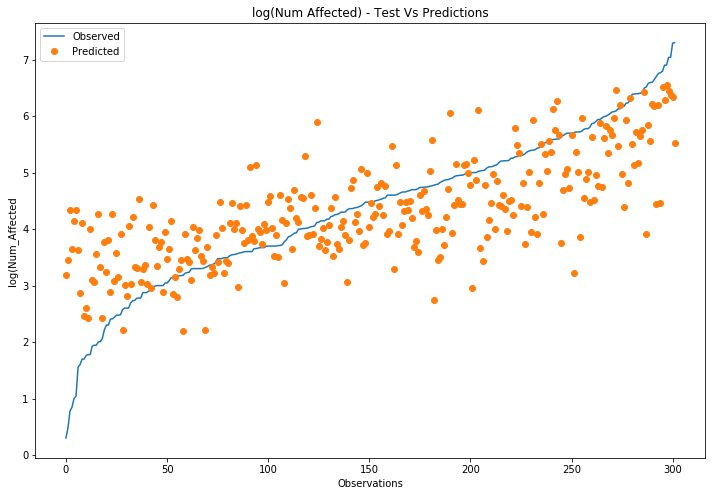

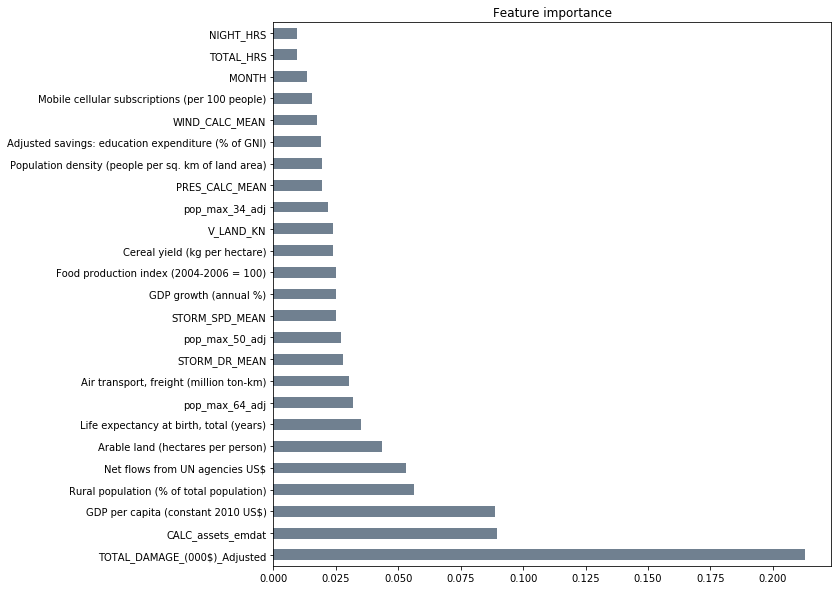

In [65]:
# Applying train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# calling the function that biulds, fits and shows results
RF_model(X_train, X_test, y_train, y_test)

# PCA______________________

# need for scaling before applying PCA

In [66]:
#from sklearn.decomposition import PCA

In [67]:
#X.shape

In [68]:
# pca = PCA(n_components=1)
# principalComponents = pca.fit_transform(X)
#X_pca = pd.DataFrame(data = principalComponents)
             #, columns = ['pc1', 'pc2'])

In [69]:
#pca.explained_variance_ratio_.sum()

In [70]:
#X_pca.head()

... let's try the Random Forest model using the PCAs as features

In [71]:
# Applying train/test split
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3)

In [72]:
'''
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)
print(f"R-squared for train set: {estimator_RF.score(X_pca, y):.2f}")
print("--------------------------------------------")
y_pred = estimator_RF.predict(X_test)
print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)
print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)
mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)
rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)
cvs = cross_val_score(estimator_RF, X_pca, y).mean()
print("cross_val_score R-squared mean = ", cvs)
'''

'\nestimator_RF = RandomForestRegressor(n_estimators=1000)\nestimator_RF.fit(X_train,y_train)\nprint(f"R-squared for train set: {estimator_RF.score(X_pca, y):.2f}")\nprint("--------------------------------------------")\ny_pred = estimator_RF.predict(X_test)\nprint("------Feature importances---------------------")\nprint(estimator_RF.feature_importances_)\nprint("--------------------------------------------")\nscore_estimator = estimator_RF.score(X_test, y_test)\nprint("R-squared for test set =", score_estimator)\nmse = mean_squared_error(y_test,y_pred)\nprint("RF estimator mean_squared_error = ", mse)\nrmse = math.sqrt(mse)\nprint("RF estimator root_mean_squared_error = ", rmse)\ncvs = cross_val_score(estimator_RF, X_pca, y).mean()\nprint("cross_val_score R-squared mean = ", cvs)\n'

In [73]:
'''
##################### Plotting results #########################

df_y = pd.DataFrame(y_test)
df_y['Pred_Total_Affected'] = y_pred
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
# plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('Num_Affected')
plt.title('Num Affected - Test Vs Predictions')
# show a legend on the plot
plt.legend()

# Display  figure
plt.show()
'''

"\n##################### Plotting results #########################\n\ndf_y = pd.DataFrame(y_test)\ndf_y['Pred_Total_Affected'] = y_pred\ndf_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot\ndf_y.reset_index(inplace=True, drop=True) #Resetting index\n    \n# plt for the Random Forest Regression results ++\nplt.figure(figsize=(12,8))\nplt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')\nplt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')\nplt.xlabel('Observations')\nplt.ylabel('Num_Affected')\nplt.title('Num Affected - Test Vs Predictions')\n# show a legend on the plot\nplt.legend()\n\n# Display  figure\nplt.show()\n"

### Hyperparameter tunning with grid search

In [74]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [76]:
parameters = {'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 20],
              'max_features':[10, 15, 20]              
             }

In [77]:
def score_rmse():
    math.sqrt(mean_squared_error(y_test,y_pred))
    return

In [78]:
estimator_RF = GridSearchCV(RandomForestRegressor(), parameters, cv = 3,
                            return_train_score = False)

In [79]:
estimator_RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [80]:
GS_results = pd.DataFrame(estimator_RF.cv_results_)
GS_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [81]:
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending = True)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
26,20,20,1000,0.438476,1
25,20,20,500,0.435517,2
17,10,20,1000,0.432141,3
21,20,15,100,0.431947,4
16,10,20,500,0.431227,5
23,20,15,1000,0.431055,6
22,20,15,500,0.429772,7
14,10,15,1000,0.428887,8
24,20,20,100,0.427498,9
13,10,15,500,0.426006,10


#### Using best parameters to fit and predict

In [82]:
estimator_RF = RandomForestRegressor(n_estimators=1000, max_features=20, max_depth=10)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y).mean()
print("cross_val_score R-squared mean = ", cvs)

R-squared for train set: 0.74
--------------------------------------------
------Feature importances---------------------
[1.30939300e-02 8.57384499e-03 8.57429699e-03 9.59347368e-03
 2.14565733e-02 3.03655002e-02 2.72588205e-02 2.59891338e-02
 2.67124350e-02 1.96822135e-01 5.73867242e-02 2.83869960e-04
 1.37267646e-03 2.96696396e-05 1.15387850e-03 1.27309442e-04
 3.89909207e-04 8.51829308e-04 5.80692501e-04 4.59831970e-04
 4.85270992e-04 3.98051139e-04 3.10359077e-03 9.46487834e-05
 1.31863113e-03 2.23508957e-04 8.14275905e-04 1.66270640e-05
 1.48536626e-03 3.76616725e-04 2.03467636e-03 2.75839755e-05
 2.91757483e-03 2.04891785e-03 1.91046443e-03 1.36158341e-03
 6.35083027e-04 8.65144464e-04 1.66963929e-04 2.94721392e-02
 5.43464124e-02 3.07239807e-02 2.18848342e-02 2.15199462e-02
 7.36993338e-02 4.39790198e-02 2.84145287e-02 1.47456654e-02
 2.35888813e-02 2.95317599e-02 5.86425261e-02 1.93633792e-02
 3.42103205e-02 3.36179888e-02 3.08981698e-02]
--------------------------------------

In [83]:
# df_y.to_csv(r'Data_output/ytest_Vs_ypred_YY.csv', index = False, sep = ';')

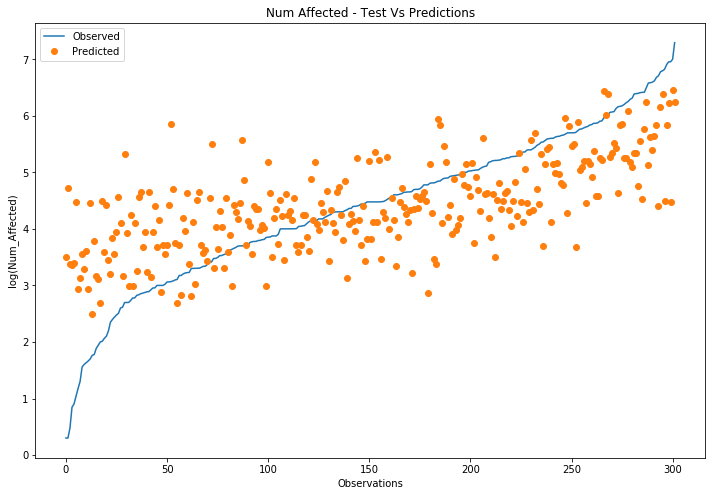

In [84]:
df_y = pd.DataFrame(y_test) #reversing log from target
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred #reversing log from target
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()
    


In [85]:
df_y.to_csv(r'Data_output/ytest_Vs_ypred.csv', index = False, sep = ';')

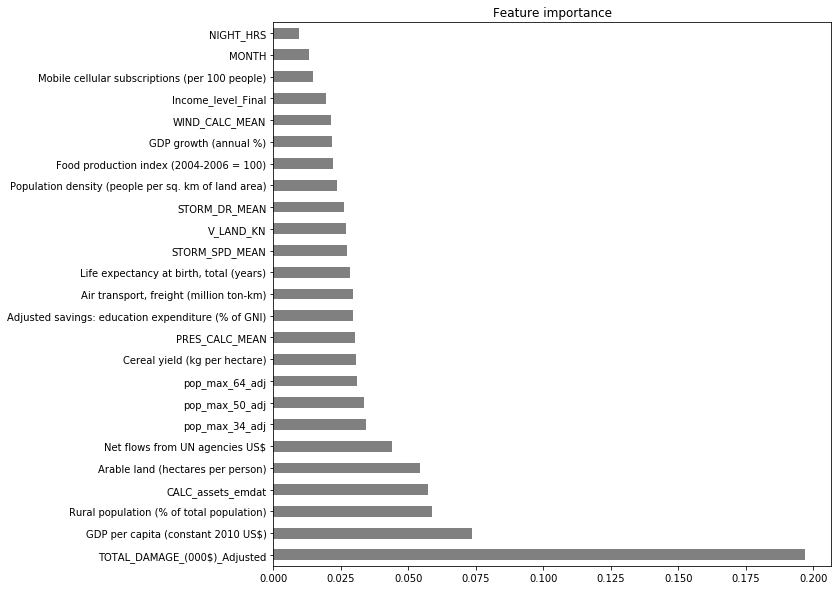

In [86]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

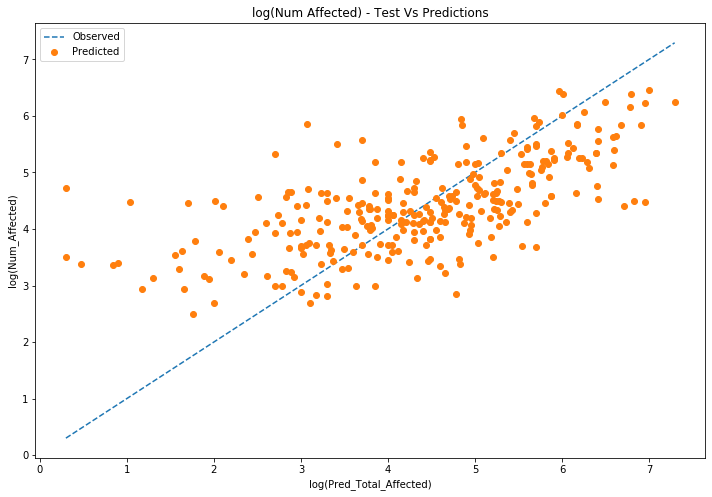

In [92]:
df_y = pd.DataFrame(y_test) #reversing log from target
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred #reversing log from target
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['TOTAL_AFFECTED'], '--', label = 'Observed')
plt.plot(df_y['TOTAL_AFFECTED'], df_y['Pred_Total_Affected'], 'o', label = 'Predicted')

plt.xlabel('log(Pred_Total_Affected)')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('log(Num Affected) - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

___________________________
________________________________